Epoch 1/100
38/38 [==============================] - 2s 16ms/step - loss: 5.0040 - categorical_accuracy: 0.1883 - val_loss: 2.6843 - val_categorical_accuracy: 0.6233
Epoch 2/100
38/38 [==============================] - 0s 10ms/step - loss: 3.4596 - categorical_accuracy: 0.3867 - val_loss: 2.2534 - val_categorical_accuracy: 0.7917
Epoch 3/100
38/38 [==============================] - 0s 10ms/step - loss: 2.6825 - categorical_accuracy: 0.5163 - val_loss: 1.9216 - val_categorical_accuracy: 0.8683
Epoch 4/100
38/38 [==============================] - 0s 10ms/step - loss: 2.4022 - categorical_accuracy: 0.6004 - val_loss: 1.5826 - val_categorical_accuracy: 0.8867
Epoch 5/100
38/38 [==============================] - 0s 9ms/step - loss: 2.0524 - categorical_accuracy: 0.6708 - val_loss: 1.3880 - val_categorical_accuracy: 0.8983
Epoch 6/100
38/38 [==============================] - 0s 10ms/step - loss: 1.7951 - categorical_accuracy: 0.7146 - val_loss: 1.3142 - val_categorical_accuracy: 0.9133
Epoch

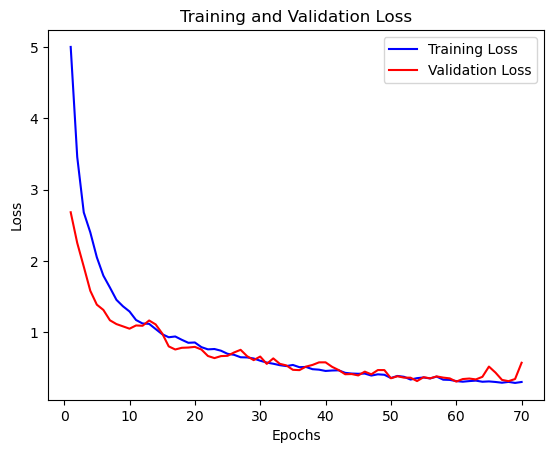

19/19 [==============================] - 0s 2ms/step
Precision: 0.9735
Recall: 0.9728
F1-score: 0.9728


In [7]:
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Directory containing the audio recordings
directory = '/kaggle/input/free-spoken-digit-dataset-fsdd/recordings'

# Load audio recordings and create labels
X = []
y = []

# Define a function to calculate MFCC
def calculate_mfcc(audio, sr, n_mfcc):
    # Apply pre-emphasis
    pre_emphasis = 0.97
    emphasized_signal = np.append(audio[0], audio[1:] - pre_emphasis * audio[:-1])
    # Compute MFCC
    mfcc = librosa.feature.mfcc(y=emphasized_signal, sr=sr, n_mfcc=n_mfcc)
    return mfcc

for file_name in os.listdir(directory):
    file_path = os.path.join(directory, file_name)
    audio, sr = librosa.load(file_path)
    mfcc = calculate_mfcc(audio, sr, n_mfcc=20)
    X.append(mfcc)
    label = int(file_name.split('_')[0])
    y.append(label)

# Pad the audio recordings to have the same length
max_length = max(mfcc.shape[1] for mfcc in X)
X = [np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1]))) for mfcc in X]

# Convert lists to numpy arrays
X = np.array(X)
# Normalize MFCCs to have zero mean and unit variance
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
y = np.array(y)

# Convert labels to categorical format
y = to_categorical(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Continue with the model construction
input_shape = X_train.shape[1:]
input_layer = Input(shape=input_shape)
conv1 = Conv1D(32, kernel_size=3, strides=1, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
bn1 = BatchNormalization()(conv1)
conv2 = Conv1D(64, kernel_size=3, strides=1, activation='relu', kernel_regularizer=l2(0.01))(bn1)
bn2 = BatchNormalization()(conv2)

# Flattening the output from the convolutional layers
flattened = Flatten()(bn2)

# Dropout regularization
dropout = Dropout(0.86)(flattened)

# Output layer
num_labels = 10  # Number of labels (numbers from 0 to 9)
output_layer = Dense(num_labels, activation='softmax')(dropout)

# Constructing the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=CategoricalCrossentropy(),
              metrics=[CategoricalAccuracy()])

# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=100, callbacks=[es])

import matplotlib.pyplot as plt

# Access the loss values from the history object
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

# Plot the loss values
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

# Predicting on the test set
y_pred = model.predict(X_test)

# Since the output is one-hot encoded, we'll convert predictions and true values back to label form for comparison
y_pred_label = np.argmax(y_pred, axis=1)
y_test_label = np.argmax(y_test, axis=1)

In [16]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)

# Printing the loss and accuracy
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

19/19 [==============================] - 0s 3ms/step - loss: 0.4608 - categorical_accuracy: 0.9717
Loss: 0.46083876490592957
Accuracy: 0.971666693687439


In [17]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test_label, y_pred_label, average='macro')
recall = recall_score(y_test_label, y_pred_label, average='macro')
f1 = f1_score(y_test_label, y_pred_label, average='macro')

# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.9714
Recall: 0.9720
F1-score: 0.9716


In [ ]:
# It's apparent that our model is doing well on F1,Precision,Recall and Accuracy fronts, however, 
# our Loss is not ideal, it would be better if we could reduce it. For this purpose, we add Transformers
# to our model

Epoch 1/100
38/38 [==============================] - 5s 34ms/step - loss: 2.4317 - categorical_accuracy: 0.4238 - val_loss: 0.4758 - val_categorical_accuracy: 0.9000
Epoch 2/100
38/38 [==============================] - 1s 24ms/step - loss: 0.8268 - categorical_accuracy: 0.7821 - val_loss: 0.3269 - val_categorical_accuracy: 0.9500
Epoch 3/100
38/38 [==============================] - 1s 21ms/step - loss: 0.5580 - categorical_accuracy: 0.8583 - val_loss: 0.2824 - val_categorical_accuracy: 0.9633
Epoch 4/100
38/38 [==============================] - 1s 21ms/step - loss: 0.4362 - categorical_accuracy: 0.9046 - val_loss: 0.2715 - val_categorical_accuracy: 0.9750
Epoch 5/100
38/38 [==============================] - 1s 21ms/step - loss: 0.3713 - categorical_accuracy: 0.9279 - val_loss: 0.2588 - val_categorical_accuracy: 0.9717
Epoch 6/100
38/38 [==============================] - 1s 21ms/step - loss: 0.3159 - categorical_accuracy: 0.9404 - val_loss: 0.2573 - val_categorical_accuracy: 0.9667
Epoc

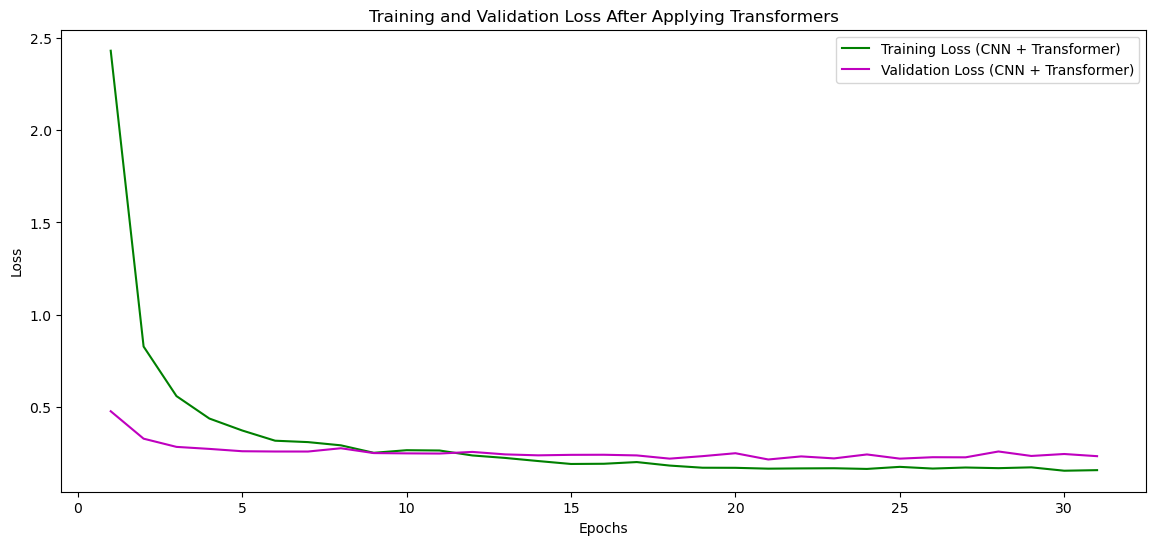

19/19 [==============================] - 0s 2ms/step
Precision: 0.9714
Recall: 0.9720
F1-score: 0.9716


In [9]:
# now using cnn-transformers
import tensorflow as tf
from tensorflow.keras import layers

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
  
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

embed_dim = 64  # Define the embedding dimension for the transformer
num_heads = 2  # Define the number of heads for the multi-head attention
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
transformer_output = transformer_block(bn2)  # Connect the transformer to the CNN

# Flattening the output from the transformer layers
flattened = Flatten()(transformer_output)

# Dropout regularization
dropout = Dropout(0.76)(flattened)

# Output layer
output_layer = Dense(num_labels, activation='softmax')(dropout)

# Constructing the model with transformer
model_with_transformer = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_with_transformer.compile(optimizer=Adam(learning_rate=0.001),
                               loss=CategoricalCrossentropy(),
                               metrics=[CategoricalAccuracy()])

# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Train the model
history_transformer = model_with_transformer.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=100, callbacks=[es])

# Get the loss values from the training history
loss_values_transformer = history_transformer.history['loss']
val_loss_values_transformer = history_transformer.history['val_loss']

# Plotting the loss values
plt.figure(figsize=(14, 6))
epochs_transformer = range(1, len(loss_values_transformer) + 1)
plt.plot(epochs_transformer, loss_values_transformer, 'g', label='Training Loss (CNN + Transformer)')
plt.plot(epochs_transformer, val_loss_values_transformer, 'm', label='Validation Loss (CNN + Transformer)')
plt.title('Training and Validation Loss After Applying Transformers')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

# Predicting on the test set
y_pred = model.predict(X_test)

# Since the output is one-hot encoded, we'll convert predictions and true values back to label form for comparison
y_pred_label = np.argmax(y_pred, axis=1)
y_test_label = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test_label, y_pred_label, average='macro')
recall = recall_score(y_test_label, y_pred_label, average='macro')
f1 = f1_score(y_test_label, y_pred_label, average='macro')

# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

In [18]:
# Evaluate the model on the test set
loss, accuracy = model_with_transformer.evaluate(X_test, y_test)

# Print the loss and accuracy values
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

19/19 [==============================] - 0s 5ms/step - loss: 0.2320 - categorical_accuracy: 0.9717
Loss: 0.23199371993541718
Accuracy: 0.971666693687439
